# Projeto final - Predição de reincidência criminal
O projeto desenvolvido tem como objetivo a predição de reincidência criminal, baseado em
dados de presidiários passados. 

## Análise e processamento dos dados

In [235]:
import gc

import pandas as pd
import numpy as np

In [236]:
def render_table(table, title):
  print(pd.Series(table).to_frame(title))

O campo **ABT_INMATE_ID** é especificado como uma *string* de 19 caracteres. Apesar do
formato livre, observa-se que os dados na verdade estão no formato **A[0-9]{18}**. Desta
forma, ignorando o primeiro caractere, um inteiro de 64 *bits* é suficiente para armazenar
este dado.

In [237]:
def parse_id(id):
  return np.int64(id[1:])

As colunas que possuem dados faltantes são associadas com tipos capitalizados. Já as
colunas completas, são associadas com tipos em minúsculo.

In [238]:
index = 'ABT_INMATE_ID'

columns = {
  'SEX': 'uint8',
  'ADMTYPE': 'Int8',
  'OFFGENERAL': 'Int8',
  'EDUCATION': 'Int8',
  'ADMITYR': 'Int16',
  'RELEASEYR': 'Int16',
  'MAND_PRISREL_YEAR': 'Int16',
  'PROJ_PRISREL_YEAR': 'Int16',
  'PARELIG_YEAR': 'Int16',
  'SENTLGTH': 'Int8',
  'OFFDETAIL': 'Int8',
  'RACE': 'Int8',
  'AGEADMIT': 'Int8',
  'AGERELEASE': 'Int8',
  'TIMESRVD': 'Int8',
  'RELTYPE': 'Int8',
  'STATE' : 'uint8'
}

O dataset acompanha um *codebook* descrevendo os possíveis valores de cada coluna,
incluindo os valores especiais para dados faltantes.

In [239]:
missing_values = {
  'ADMTYPE': '9',             # 9 = missing.
  'OFFGENERAL': [ '5', '9' ], # 5 = other/unspecified; 9 = missing.
  'EDUCATION': '99',          # 99 = ungraded/unknown.
  'ADMITYR': '9999',          # 9999 = missing.
  'RELEASEYR': '9999',        # 9999 = missing.
  'SENTLGTH': '9',            # 9 = missing.
  'OFFDETAIL': '99',          # 14 = other/unspecified; 99 = missing.
  'RACE': '9',                # 9 = missing.
  'AGEADMIT': '9',            # 9 = missing.
  'AGERELEASE': '9',          # 9 = missing.
  'TIMESRVD': '9',            # 9 = missing.
  'RELTYPE': '9'              # 9 = missing.
}

In [240]:
data = pd.read_csv(
  'data/nan/full.tsv',
  sep = '\t',
  nrows = 2_000_000,
  usecols = [ index ] + list(columns),
  dtype = columns,
  na_values = missing_values,
  converters = { index: parse_id }
)

In [241]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 18 columns):
ABT_INMATE_ID        int64
SEX                  uint8
ADMTYPE              Int8
OFFGENERAL           Int8
EDUCATION            Int8
ADMITYR              Int16
RELEASEYR            Int16
MAND_PRISREL_YEAR    Int16
PROJ_PRISREL_YEAR    Int16
PARELIG_YEAR         Int16
SENTLGTH             Int8
OFFDETAIL            Int8
RACE                 Int8
AGEADMIT             Int8
AGERELEASE           Int8
TIMESRVD             Int8
RELTYPE              Int8
STATE                uint8
dtypes: Int16(5), Int8(10), int64(1), uint8(2)
memory usage: 85.8 MB


### Dados faltantes
Vamos analisar os dados faltantes.

In [242]:
missing_data = data.isnull().mean()

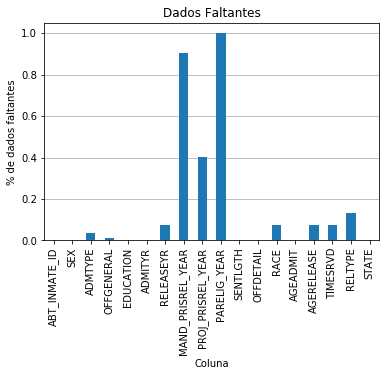

In [243]:
ax = missing_data.plot(
  kind = 'bar',
  title = 'Dados Faltantes',
  zorder = 2 # bars over grid
)

ax.set(
  xlabel = 'Coluna',
  ylabel = '% de dados faltantes'
)

ax.yaxis.grid();

As seguintes colunas apresentam muitos dados faltantes, e portanto serão desconsideradas:
- MAND\_PRISREL\_YEAR: ano de soltura mandatório
- PROJ\_PRISREL\_YEAR: ano de soltura projetado
- PARELIG\_YEAR: ano de eligibilidade à condicional

In [244]:
data, data_full = data.drop(
  [
    'MAND_PRISREL_YEAR',
    'PROJ_PRISREL_YEAR',
    'PARELIG_YEAR'
  ],
  axis = 1
), data;

Ainda, as instâncias com dados faltantes nas demais colunas serão removidas.

In [245]:
data = data.dropna();

In [246]:
render_table(
  {
    'totais': data_full.shape[0],
    'completas': data.shape[0]
  },
  'instâncias'
);

           instâncias
totais        2000000
completas     1565130


### Target
Nosso target é predizer se um prisioneiro apresentou reincidência. Como esta informação
está implícita no dataset, precisamos calculá-la. Consideraremos que há reincidência para
uma instância se há uma outra instância com a mesma identificação, em um ano superior de
admissão. Para tal, é necessário definir uma margem de reincidência, pois os dados não
podem discernir se haverá ou não reincidência no futuro. Considerando as limitações do
dataset, definimos uma margem de 4 anos, o que já limita os dados consideravelmente,
considerando que os últimos 4 anos de dados constituem 21.9% do total.

In [247]:
target = 'RECIDIVIST'

In [248]:
data_sorted = data.sort_values(by = ['ADMITYR'])

data = data_sorted.assign(
  **{
    target: data_sorted.duplicated(
      subset = index,
      keep = 'last'
    )
  }
)

In [249]:
recidivism_margin = 4

In [250]:
release_year_counts = data['RELEASEYR'] \
  .value_counts(normalize = True) \
  .sort_index(ascending = False)

In [251]:
print(
  'Porcentagem dos dados dispostos nos últimos {} anos: {:.1%}.'.format(
    recidivism_margin,
    release_year_counts.head(recidivism_margin).sum()
  )
)

Porcentagem dos dados dispostos nos últimos 4 anos: 13.9%.


In [252]:
data[target].value_counts(normalize = True)

False    0.530868
True     0.469132
Name: RECIDIVIST, dtype: float64

In [253]:
data, data_complete = data[
  data['ADMITYR'] <= (release_year_counts.index.max() - recidivism_margin)
], data;

In [254]:
render_table(
  {
    'completas': data_complete.shape[0],
    'até 2010': data.shape[0]
  },
  'instâncias'
);

           instâncias
completas     1565130
até 2010      1434340


### Features 
A feature **RACE** foi desconsiderada para o aprendizado por motivos éticos, de forma a não
reproduzir preconceitos intrínsecos da nossa sociedade.

In [255]:
features = [
  'SEX',
  'ADMTYPE',
  'OFFGENERAL',
  'EDUCATION',
  'SENTLGTH',
  'OFFDETAIL',
  'AGEADMIT',
  'AGERELEASE',
  'TIMESRVD',
  'RELTYPE',
  # 'RACE'
]

disconsidered_features = [
  index,
  'ADMITYR',
  'RELEASEYR',
  'STATE'
]

#### Estudo de caso: Etnia
Além de desconsiderar a *feature* **RACE**, podemos analisar qual seria seu impacto no
modelo. Para discernir sobre o impacto


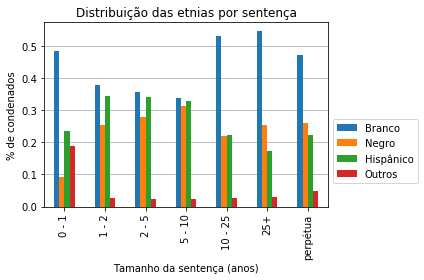

In [303]:
# data_complete.groupby(['RACE', 'SENTLGTH']).size()
frequency = pd.crosstab(
  data_complete['SENTLGTH'],
  data_complete['RACE'],
  normalize = 'index'
).rename(
  index = {
    0: '0 - 1',
    1: '1 - 2',
    2: '2 - 5',
    3: '5 - 10',
    4: '10 - 25',
    5: '25+',
    6: 'perpétua'
  },
  columns = {
    1: 'Branco',
    2: 'Negro',
    3: 'Hispânico',
    4: 'Outros'
  }
)

ax = frequency.plot.bar(zorder = 2)

ax.legend(bbox_to_anchor=(1.0, 0.5))

ax.yaxis.grid();

ax.set(
  title = 'Distribuição das etnias por sentença',
  xlabel = 'Tamanho da sentença (anos)',
  ylabel = '% de condenados'
);

fig = ax.get_figure()
fig.tight_layout()
fig.savefig('images/race.png')

In [256]:
data = data.drop(disconsidered_features, axis = 1);

Todas as *features*, exceto as relativas a anos, são categóricas. Portanto, precisamos
codificá-las.

In [257]:
data = pd.get_dummies(
  data,
  columns = features,
  drop_first = True
);

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434340 entries, 1199349 to 275491
Data columns (total 42 columns):
RECIDIVIST      1434340 non-null bool
SEX_2           1434340 non-null uint8
ADMTYPE_2       1434340 non-null uint8
ADMTYPE_3       1434340 non-null uint8
OFFGENERAL_2    1434340 non-null uint8
OFFGENERAL_3    1434340 non-null uint8
OFFGENERAL_4    1434340 non-null uint8
SENTLGTH_1      1434340 non-null uint8
SENTLGTH_2      1434340 non-null uint8
SENTLGTH_3      1434340 non-null uint8
SENTLGTH_4      1434340 non-null uint8
SENTLGTH_5      1434340 non-null uint8
SENTLGTH_6      1434340 non-null uint8
OFFDETAIL_2     1434340 non-null uint8
OFFDETAIL_3     1434340 non-null uint8
OFFDETAIL_4     1434340 non-null uint8
OFFDETAIL_5     1434340 non-null uint8
OFFDETAIL_6     1434340 non-null uint8
OFFDETAIL_7     1434340 non-null uint8
OFFDETAIL_8     1434340 non-null uint8
OFFDETAIL_9     1434340 non-null uint8
OFFDETAIL_10    1434340 non-null uint8
OFFDETAIL_11    1434340 n

## Aprendizado

In [259]:
from types import SimpleNamespace as Object

In [260]:
features = set(data)
features.remove(target)

### Validação

In [261]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

N_FOLDS = 5

kfold = KFold(n_splits = N_FOLDS)

phases = {
  'Train': lambda score: score.train, # get train score
  'Test': lambda score: score.test   # get test score
}

def cross_validate(alg):
  scores = {
    metric: Object(
      function = function,
      train = [],
      test = []
    )
    for metric, function in {
      'accuracy': accuracy_score,
      'precision': precision_score,
      'recall': recall_score,
      'f1': f1_score,
    }.items()
  }

  for train, test in kfold.split(data):
    train = data.iloc[train]
    test  = data.iloc[test]

    model = alg.fit(train[features], train[target])

    prediction = Object(
      train = model.predict(train[features]),
      test  = model.predict(test[features])
    )

    for score in scores.values():
      score.train.append(
        score.function(train[target], prediction.train)
      )
      score.test.append(
        score.function(test[target], prediction.test)
      )

  for score in scores.values():
    score.train = np.mean(score.train)
    score.test  = np.mean(score.test)

  return scores

### Naive Bayes

In [262]:
from sklearn.naive_bayes import GaussianNB

gnb = cross_validate(GaussianNB())

gnb

{'accuracy': namespace(function=<function accuracy_score at 0x7fb372654730>, test=0.5608119413807048, train=0.5617850370205113),
 'precision': namespace(function=<function precision_score at 0x7fb372654e18>, test=0.5364844725232328, train=0.5385401775729882),
 'recall': namespace(function=<function recall_score at 0x7fb372654ea0>, test=0.8783306757878773, train=0.8828439890802248),
 'f1': namespace(function=<function f1_score at 0x7fb372654b70>, test=0.6628773142823186, train=0.6688280682740964)}

### Random Forest

In [263]:
from sklearn.ensemble import RandomForestClassifier

rfc = cross_validate(
  RandomForestClassifier(
    n_estimators = 10,
    n_jobs = 4,
    verbose = 1
  )
)

gc.collect();

rfc

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    8.8s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    8.7s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


{'accuracy': namespace(function=<function accuracy_score at 0x7fb372654730>, test=0.6211372477934102, train=0.6473954920032907),
 'precision': namespace(function=<function precision_score at 0x7fb372654e18>, test=0.6111688479186957, train=0.6299469461925387),
 'recall': namespace(function=<function recall_score at 0x7fb372654ea0>, test=0.6959728807202781, train=0.7171327391753824),
 'f1': namespace(function=<function f1_score at 0x7fb372654b70>, test=0.6440963558519514, train=0.6706072698778935)}

### LightGBM

In [264]:
import lightgbm as lgb

data_lgb = lgb.Dataset(
  data[features],
  label = data[target]
)

data_lgb.raw_data = None

gc.collect();

In [265]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

lgb.cv(
  {
    'num_leaves': 31,
    'objective': 'binary',
    # 'metric': 'auc',
    'num_threads': 3,
    # 'device_type': 'gpu'
  },
  data_lgb,
  10,
  nfold = 5,
  feval = lgb_f1_score
)

{'binary_logloss-mean': [0.6847886837320477,
  0.6780077654837332,
  0.6724335184007905,
  0.6678778836504251,
  0.664132363019305,
  0.6609453151473662,
  0.6582653580907583,
  0.6559877853922662,
  0.65402259100095,
  0.6523487558799648],
 'binary_logloss-stdv': [3.0018346631588307e-05,
  6.806049303087913e-05,
  9.024639030779288e-05,
  0.00010771191526981785,
  0.00012536701039592472,
  0.00014154068207411206,
  0.0001848306008593801,
  0.00020308039275801842,
  0.00022502433639372328,
  0.0002110280215330242],
 'f1-mean': [0.6629662660977026,
  0.6599764173413055,
  0.6522229859285066,
  0.6518925469811955,
  0.6514944326205857,
  0.652569278531657,
  0.650552322323066,
  0.6529218158264627,
  0.65053590388712,
  0.650265007826835],
 'f1-stdv': [0.0008041486476503717,
  0.00028630119464909625,
  0.0027703365294119704,
  0.0029986923625661276,
  0.0013182146898451203,
  0.0018857330118956948,
  0.0025078876082659353,
  0.003429580138956902,
  0.0018762915546120197,
  0.001772675994

In [266]:
gc.collect();

### XGBoost

In [267]:
from xgboost import XGBClassifier

xgb = cross_validate(
  XGBClassifier(
    n_jobs = 4
  )
)

In [268]:
xgb

{'accuracy': namespace(function=<function accuracy_score at 0x7fb372654730>, test=0.6218574396586584, train=0.6350307458482647),
 'precision': namespace(function=<function precision_score at 0x7fb372654e18>, test=0.6164695618739088, train=0.6226708576266199),
 'recall': namespace(function=<function recall_score at 0x7fb372654ea0>, test=0.6781433162283192, train=0.6878469415122309),
 'f1': namespace(function=<function f1_score at 0x7fb372654b70>, test=0.6384168259671801, train=0.6533583532739587)}